<a href="https://colab.research.google.com/github/HENILCHOPRA/diabteic-retinopathy-wEfficientnet/blob/main/Diabetic_Retinopathy_w_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

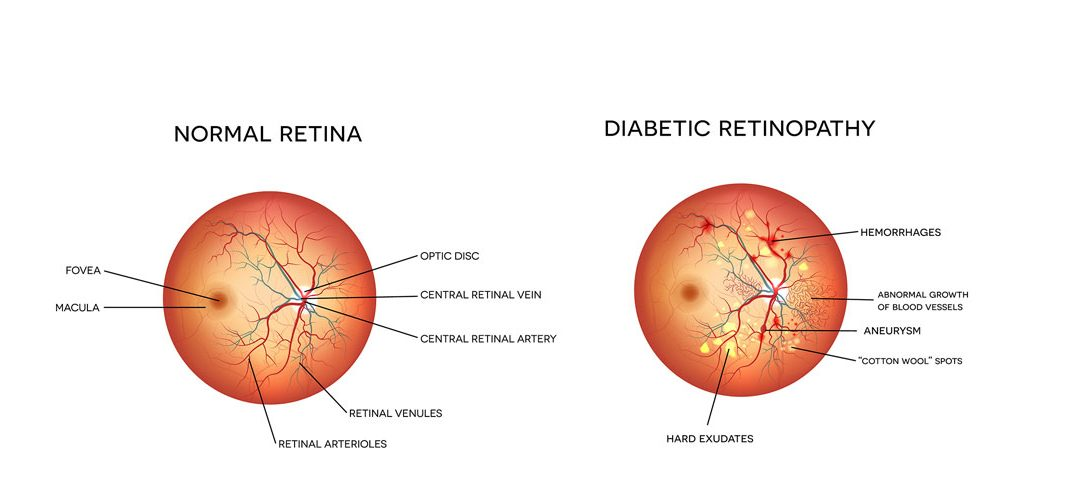

*   What is Diabetic Retinopathy?
A complication of diabetes that affects the eyes.

> *  Diabetic retinopathy is caused by damage to the blood vessels in the tissue at the back of the eye (retina). Poorly controlled blood sugar is a risk factor. Early symptoms include floaters, blurriness, dark areas of vision, and difficulty perceiving colors. Blindness can occur.

*   Goal of this notebook.
> *   Here I have used kaggle dataset of high resoultion images of human eye retina with annotated severity level.
> *   I used a vanilla Efficient model (EfficientnetB3) model on resized 947 sample images of size (256,256,3). 
> * Post that I augmented the model with attention layer to focus on specific area on learning feature from that region.  

Credits
> * [Dataset](https://www.kaggle.com/c/diabetic-retinopathy-detection/overview)
> * [Keras Efficientnet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)
> * [Attention model](https://www.kaggle.com/kmader/inceptionv3-for-retinopathy-gpu-hr#Attention-Model)

*Please refer [My Github](https://www.kaggle.com/kmader/inceptionv3-for-retinopathy-gpu-hr#Attention-Model) for preprocceing steps.*





In [ ]:
!pip3 install --upgrade pandas

In [1]:
from tensorflow.keras.applications import EfficientNetB3
import pickle
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
import albumentations as albu
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from pylab import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

%matplotlib inline

SIZE = 256
batch_size = 24
channels = 3
classes = 5

In [2]:
!cp '/content/drive/MyDrive/Colab Notebooks/Data/DR/train_df.pickle' -d '/content/'

In [3]:
! cp '/content/drive/MyDrive/Colab Notebooks/Data/DR/all_labels.csv' -d '/content/'

In [4]:
# ! cp '/content/drive/MyDrive/Colab Notebooks/Data/DR/train_images.pickle' -d '/content/'
! cp '/content/drive/MyDrive/Colab Notebooks/Data/DR/train_images_256.pickle' -d '/content/'

In [5]:
! cp '/content/drive/MyDrive/Colab Notebooks/Data/DR/train_labels.pickle' -d '/content/'

In [6]:
df = pd.read_csv('/content/all_labels.csv')

df[['ID', 'eye']] = df['image'].str.split('_', 1, expand=True)
df['eye'].replace({'left':0, 'right':1}, inplace = True)
df['image'] = df['image'] + '.jpeg'

In [7]:
df.head()

,image,level,ID,eye
0,10_left.jpeg,0,10,0
1,10_right.jpeg,0,10,1
2,13_left.jpeg,0,13,0
3,13_right.jpeg,0,13,1
4,15_left.jpeg,1,15,0


*The dataset is skewed as it can be seen from the hist*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f134793ad50>,
      dtype=object)

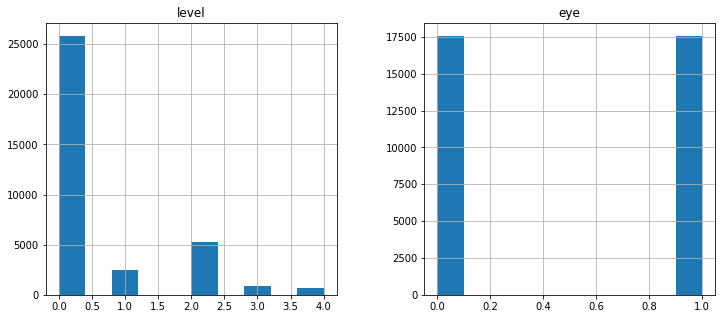

In [8]:
df[['level', 'eye']].hist(figsize = (12, 5))

*We will sample the dataset while balance the number of data for each level of severity and eye. Our we have kept sample size of 100 for each combination of eye and severity.*
*The code has already been executed locally and we will directlyn use the dumped pickle of the training dataframe and respective image*

In [9]:
#train_df = df.groupby(['level', 'eye']).apply(lambda x: x.sample(100, replace = True))
#train_df.drop_duplicates(inplace = True)



file = open('/content/train_df.pickle', 'rb')
train_df = pickle.load(file)
file = open('/content/train_images_256.pickle', 'rb')
images_arr = pickle.load(file)
file = open('/content/train_labels.pickle', 'rb')
label_arr = pickle.load(file)
label_arr = to_categorical(label_arr)


In [10]:
train_df.head()

image  level     ID  eye
level eye                                          
0     0   7466    9390_left.jpeg      0   9390    0
          24078  30413_left.jpeg      0  30413    0
          6012    7588_left.jpeg      0   7588    0
          12994  16335_left.jpeg      0  16335    0
          23498  29702_left.jpeg      0  29702    0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13479d9d90>,
      dtype=object)

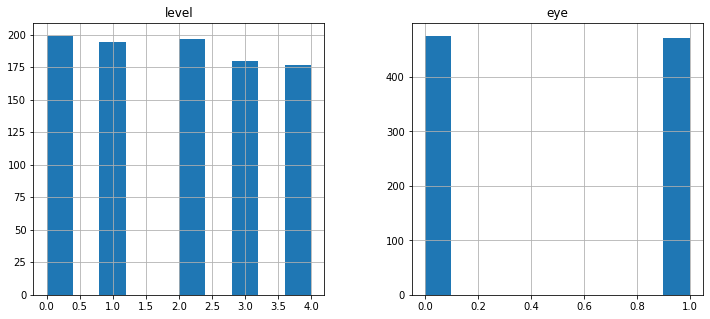

In [11]:
train_df[['level', 'eye']].hist(figsize = (12, 5))

In [12]:
train_df.reset_index(inplace=True, drop=True)

sample_1 = train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(1, replace = True))
sample_1

image  level     ID  eye
level eye                                         
0     0   85    15538_left.jpeg      0  15538    0
      1   168  19535_right.jpeg      0  19535    1
1     0   233   20182_left.jpeg      1  20182    0
      1   336  43030_right.jpeg      1  43030    1
2     0   485   23539_left.jpeg      2  23539    0
      1   565   9569_right.jpeg      2   9569    1
3     0   608   29418_left.jpeg      3  29418    0
      1   763  19920_right.jpeg      3  19920    1
4     0   825   17749_left.jpeg      4  17749    0
      1   882  31602_right.jpeg      4  31602    1

<Figure size 432x288 with 0 Axes>

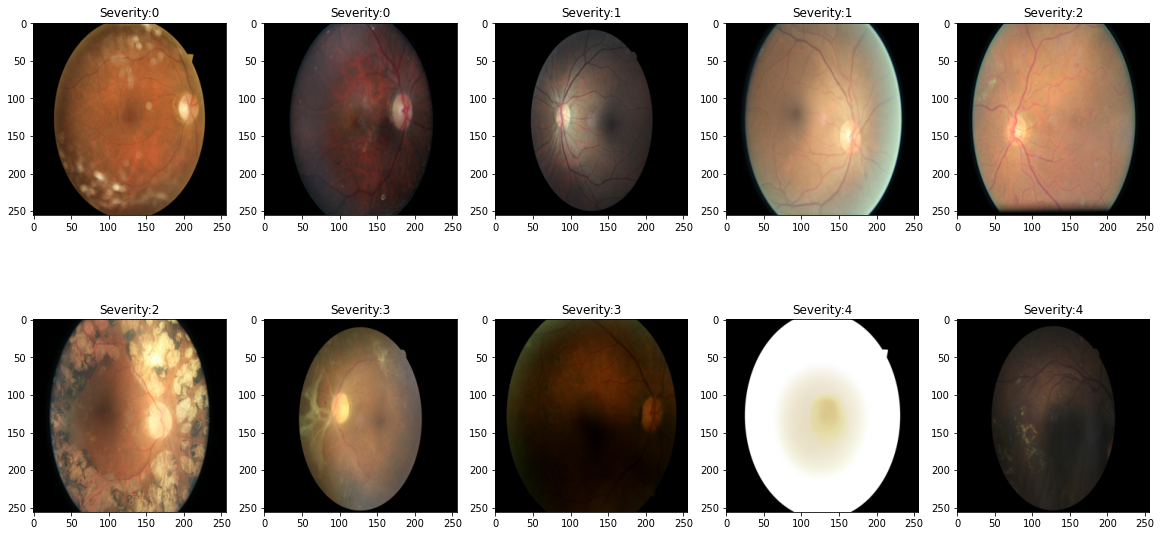

In [13]:
sample_ids = sample_1['ID'].tolist()
sample_images = []
all_ids = train_df['ID'].tolist()
for ids in sample_ids:
    sample_images.append(images_arr[all_ids.index(ids)])

plt.figure()

f, axarr = plt.subplots(2,5, figsize = (20, 10)) 
for i in range(len(sample_images)):
    axarr[i//5, i%5].imshow(sample_images[i])
    axarr[i//5, i%5].set_title(f'Severity:{i//2}')



---



<h1>Efficientnet with Attention Model</h1>

---



In [29]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels=None, mode='fit', batch_size=24, dim=(SIZE, SIZE), channels=channels, n_classes=classes, shuffle=True, augment=False):
        
        #initializing the configuration of the generator
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method to be called after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return numbers of steps in an epoch using samples & batch size
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    #this method is called with the batch number as an argument to #obtain a given batch of data
    def __getitem__(self, index):
        #generate one batch of data
        #generate indexes of batch
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        #generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            #generate pre-processed image
            img = self.images[ID]
            #image rescaling
            img = img.astype(np.float32)/255.
            #resizing as per new dimensions
            # img = resize_img(img, self.dim)
            X[i] = img
            
        #generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentation on the training dataset
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            
    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                   albu.VerticalFlip(p=0.5),
                                   albu.GridDistortion(p=0.2),
                                   albu.ElasticTransform(p=0.2)])
        return composition(image=img)['image']
    
    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

In [30]:
X_train, X_test, y_train, y_test = train_test_split(images_arr, label_arr, test_size=0.30, random_state=42)
train_data_generator = DataGenerator(np.array(X_train), np.array(y_train) , augment=True) 
valid_data_generator = DataGenerator(np.array(X_test), np.array(y_test), augment=False)


<h2>Data Augmentation</h2>

In [16]:
img_augmentation = Sequential(
    [
        keras.layers.RandomRotation(factor=0.15),
        keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        keras.layers.RandomFlip(),
        keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

<h2>EfficientNetB3 Model</h2>

In [20]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, channels), classes=classes, drop_connect_rate=0.4)
# base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 8, 8, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 7685      
                                                                 
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
_________________________________________________________________


In [21]:
optimizer = Adam(lr=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
epochs = 30
model_history = model.fit_generator(train_data_generator, validation_data = valid_data_generator, callbacks = [early_stop, rlrop],verbose = 1, epochs = epochs)

#saving the trained model weights as data file in .h5 format
model.save_weights("DR_efficientnetb0_weights.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
27/27 [==============================] - 55s 1s/step - loss: 1.6144 - accuracy: 0.2593 - val_loss: 1.6265 - val_accuracy: 0.1856 - lr: 1.0000e-04
Epoch 2/30
27/27 [==============================] - 32s 1s/step - loss: 1.5456 - accuracy: 0.2932 - val_loss: 1.6154 - val_accuracy: 0.2235 - lr: 1.0000e-04
Epoch 3/30
27/27 [==============================] - 32s 1s/step - loss: 1.4821 - accuracy: 0.3657 - val_loss: 1.6133 - val_accuracy: 0.1970 - lr: 1.0000e-04
Epoch 4/30
27/27 [==============================] - 32s 1s/step - loss: 1.4059 - accuracy: 0.3812 - val_loss: 1.6807 - val_accuracy: 0.1818 - lr: 1.0000e-04
Epoch 5/30
27/27 [==============================] - 32s 1s/step - loss: 1.3325 - accuracy: 0.4552 - val_loss: 1.6951 - val_accuracy: 0.1932 - lr: 1.0000e-04
Epoch 6/30
27/27 [==============================] - 32s 1s/step - loss: 1.2460 - accuracy: 0.4583 - val_loss: 1.6765 - val_accuracy: 0.1894 - lr: 1.0000e-04
Epoch 7/30
27/27 [==============================] - 32s 1s

<h2>Attention Model</**h2**>

In [23]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model

In [24]:
input_layer = Input(shape=(256,256,3))

# base_model.trainable = False
pt_depth = base_model.get_output_shape_at(0)[-1]
pt_features = base_model(input_layer)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(y_train.shape[-1], activation = 'softmax')(dr_steps)
attn_model = Model(inputs = [input_layer], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

attn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
attn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb3 (Functional)    (None, 8, 8, 1536)   10783535    ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 1536)  6144        ['efficientnetb3[1][0]']         
 alization)                                                                                       
                                                                                              

In [27]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('DR')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [38]:
attn_model.fit_generator(train_data_generator, 
                           steps_per_epoch = np.ceil(len(X_train) / 24)-1,
                           validation_data = valid_data_generator, 
                           validation_steps = np.ceil(len(X_test) / 24)-1,
                              epochs = 25, 
                              callbacks = callbacks_list,
                             workers = 0, 
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/25
27/27 [==============================] - ETA: 0s - loss: 1.2090 - categorical_accuracy: 0.4707 - top_2_accuracy: 0.7500
Epoch 00001: val_loss did not improve from 1.61120
27/27 [==============================] - 42s 2s/step - loss: 1.2090 - categorical_accuracy: 0.4707 - top_2_accuracy: 0.7500 - val_loss: 1.8678 - val_categorical_accuracy: 0.1856 - val_top_2_accuracy: 0.3712 - lr: 0.0010
Epoch 2/25
27/27 [==============================] - ETA: 0s - loss: 1.1935 - categorical_accuracy: 0.4769 - top_2_accuracy: 0.7577
Epoch 00002: val_loss did not improve from 1.61120
27/27 [==============================] - 41s 2s/step - loss: 1.1935 - categorical_accuracy: 0.4769 - top_2_accuracy: 0.7577 - val_loss: 1.6420 - val_categorical_accuracy: 0.2045 - val_top_2_accuracy: 0.4129 - lr: 0.0010
Epoch 3/25
27/27 [==============================] - ETA: 0s - loss: 1.1666 - categorical_accuracy: 0.5108 - top_2_accuracy: 0.7623
Epoch 00003: val_loss did not improve from 1.61120
27/27 [=======

In [ ]:
import keras.backend as K
rand_idx = np.random.choice(range(len(X_test)), size = 6)
attn_func = K.function(inputs = [(attn_model.get_output_shape_at(0)), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis', 
                   vmi n = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = attn_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)